# Neurophysiological signal processing and Network analysis

# Practical Session ERPs (11/03/25)

## Intro

The goal of this practical session is to process EEG data to obtain the Event-Related Potential (ERP) for each subject included in the dataset. The dataset consists of 60 healthy controls in 6 different decades. In each decade five men and five women are included to obtain a gender balanced dataset. For each of these subjects, the language paradigm for word order (shown in the demo, and shortly explained below) was used while recording the EEG.


Your task will be to implement the different preprocessing steps and learn how to work with the [**MNE-Python library**](https://mne.tools/stable/index.html). Have a look at the tutorials and examples on the website to help you with the exercises. To keep it simple, we will start by preprocessing and visualizing the data for one individual. In the second part, you can combine all steps in one function to process the data of all subjects and obtain the grand-average waveform.

### The language paradigm for grammar: word order

The language paradigm in this experiment is used to check if the subject can detect errors in the word order in a sentence. Therefor, a sentence is shown to the subject, word after word, after which the subject has to press a button to indicate whether the word order in the sentence was correct or not. To give you an example:

* De logopediste luistert naar de vrij goede spraak van de patiënt. (The speech therapist listens to the fairly good speech of the patient.)
* De logopediste luistert naar de goede vrij spraak van de patiënt. (The speech therapist listens to the good fairly speech of the patient.)
* Mijn neef is met een erg snelle wagen onderweg naar de winkel. (My cousin is on his way to the store in a very fast car.)
* Mijn neef is met een snelle erg wagen onderweg naar de winkel. (My cousin is on his way to the store in a fast very car.)

Or thus: in the correct sentences the word order is ... - adverb - adjective - noun - ..., while in the incorrect sentences it is ... - adjective - adverb - noun -... . Each word in these sentences is presented for 500ms followed by 500ms empty screen. At the end of the sentence, the subject is instructed to determine if the word order in the sentence was correct or incorrect, and to press the corresponding button.

At the beginning of the experiment, six sentences are presented to the subject to make sure that he/she understands the exercise. After this, the 'real' experiment is started. Sixty sentences are presented to each subject, thirthy correct sentences and thirty incorrect sentences, in a random order. In order to make sure that subjects don't loose their attention, after fifteen sentences a small break is included. Each sentence is marked during the EEG recording with the following codes:
* Correct sentences:
    * S11: Start sentence
    * S12: adjective
    * S14: noun
    * S15: adverb (not always indicated)
    * S72: correct button press
    * S70: incorrect button press
* Incorrect sentences:
    * S22: Start sentence
    * S16: adverb
    * S18: noun
    * S74: correct button press
    * S76: incorrect button press
    
Other markers that are used:
* S60: Start of the true experiment
* S80: Start of break
* S90: End of break

In the case of an incorrect sentence, we expect to see a larger positive response in the brain around 600 ms after the onset of the adverb, i.e. in the evoked potential we expect to see a P600 component.

In [ ]:
!pip install mne


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Import the necessary libraries and the data

In [2]:
import os
import numpy as np
import mne
from mne.preprocessing import ICA
import scipy.signal as signal
import glob

# %matplotlib qt   #seems not working with colab
# %matplotlib inline
import matplotlib.pyplot as plt

# This line might be needed if you have a Mac
#os.environ['QT_MAC_WANTS_LAYER']='1'

The data was recorded using the Brain Vision system. In this system, three different files are needed to have the complete information of the recording.

**Question 1:** What type of information can you find in each file?

In [4]:
# !ls 'drive/MyDrive/Networkanalysis_practica/Data'
!ls 'Data/Data'

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
# DATA_DIR = 'drive/MyDrive/Networkanalysis_practica/Data/'
DATA_DIR = 'Data/Data/'
files = sorted(glob.glob(DATA_DIR + '*.vhdr'))

#find data types
file_types = {os.path.splitext(file)[1] for file in os.listdir(DATA_DIR)}
print(file_types)


{'.eeg', '.vhdr', '.vmrk'}


**Answer 1:**
<br><br>
There are 3 different types of files in the provided folder: .eeg, .vhdr, and .vmrk.

**1. eeg:** Binary file that contains the raw EEG data as well as additional signals that have been recorded along with the EEG.

**2. vhdr:** Text file that contains the recording parameters used for the respective .eeg file of the same name as well as additional meta-information.

**3. vmrk:** Text file that describes the events that were collected during the respective recording of the EEG data of the same name.
<br><br>


## Step 2: Preprocess the data of the first subject (D1M02)

As mentioned in the introduction, we will start by preprocessing the data of one individual: subject D1M02.

### Load the data

Load the raw data and answer the following questions:

**Question 2:**

* How many, and which, channels were used to record the EEG?
* What is the sampling frequency?
* Has the data been filtered during the recording? If so, which cut-off frequencies were used?
* How long did the experiment take?

In [12]:
file = files[0]
raw = mne.io.read_raw_brainvision(file, preload=True)
print(raw.info)

Extracting parameters from Data/Data\ExpWV_D1M02.vhdr...
Setting channel info structure...
Reading 0 ... 648999  =      0.000 ...  1297.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 31 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-07-08 14:19:09 UTC
 nchan: 31
 projs: []
 sfreq: 500.0 Hz
>


**Answer 2:**

1. The EEG recording used 31 channels following a 10-20 distribution.
2. The sampling frequency used was 500Hz.
3. The data has been filtered with a lowpass filter using a cut-off frequency of 250Hz (only allowing signals with frequency < 250Hz to be recorded). The powerline frequency (50Hz for Europe) appears to not have been filtered during the recording.
4. The recording took ~1298 seconds, equivalent to 21.6 minutes.

### Plot the data

Plot both the raw data, the sensor positions and the power spectral density of the data (limit to 100 Hz). Trying to plot the sensor positions will initially give an error. Why? How can you solve this knowing that a 10-20 montage was used for the position of the electrodes?

**Question 3:** What do you notice? What artefacts do you already see?

Using matplotlib as 2D backend.


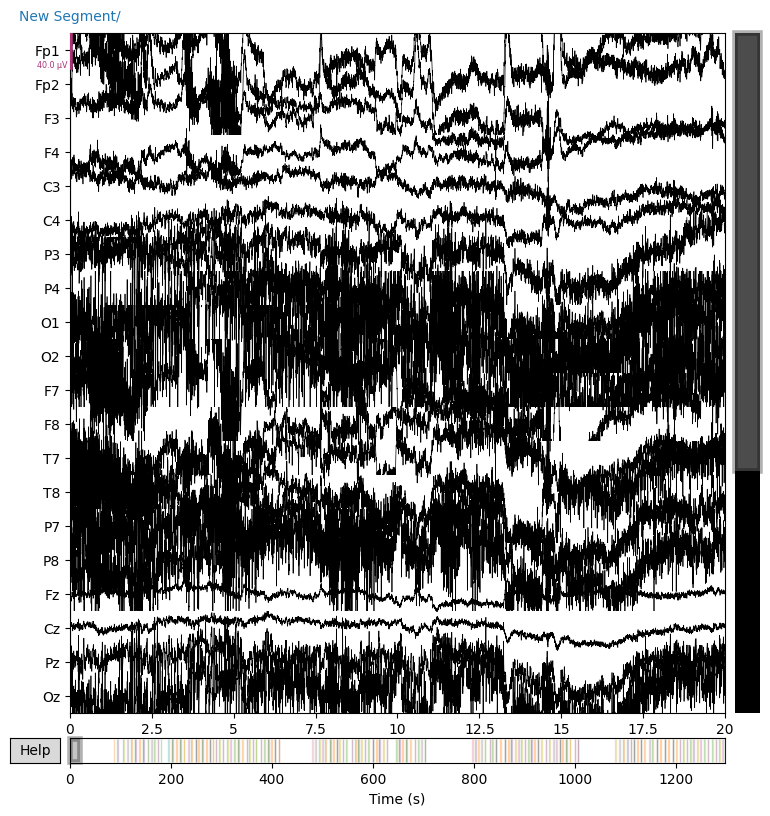

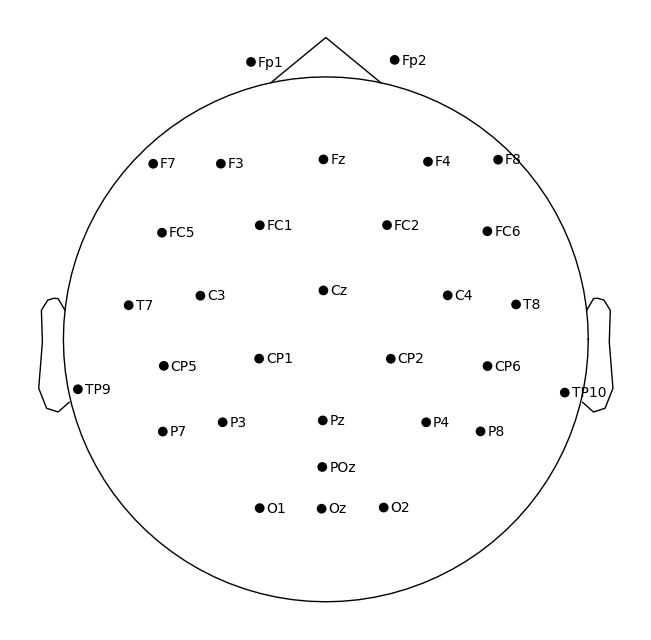

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


c:\Users\cesar_5w126xu\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


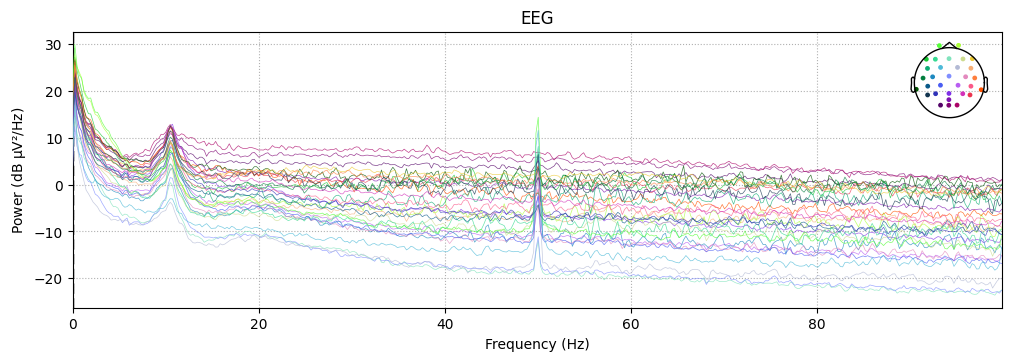

In [13]:
fig = raw.plot(duration = 20)
raw.set_montage('standard_1020')
fig = raw.plot_sensors(show_names=True)
fig = raw.compute_psd(fmax= 100).plot()

**Answer 3:**
1. error: the data doesn't contain location info (even though they have the channel names). When knowing it's 10-20 system, we can set montage which will give reference location.

2. There is a clear peak at 50Hz. This artifact is caused by the powerline frequency of Europe.

  There is also a clear peak around 10Hz that can possibly be attributed to eye-blinking, as eye-blinking contaminates the signal on frequencies ranging from ~0Hz to 12Hz [1].


Referece:

[1]. Kumar. A, Veluvolu. K, "*Eye-blink artifact removal from single channel EEG with k-means and SSA*" , Scientific Reports, 2021, doi: https://doi.org/10.1038/s41598-021-90437-7.

### Filter the data

**Question 4:** Filter the data using a second-order Butterworth band-pass filter of 0.3-30 Hz and a 50Hz notch-filter. Plot the filtered data.

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB



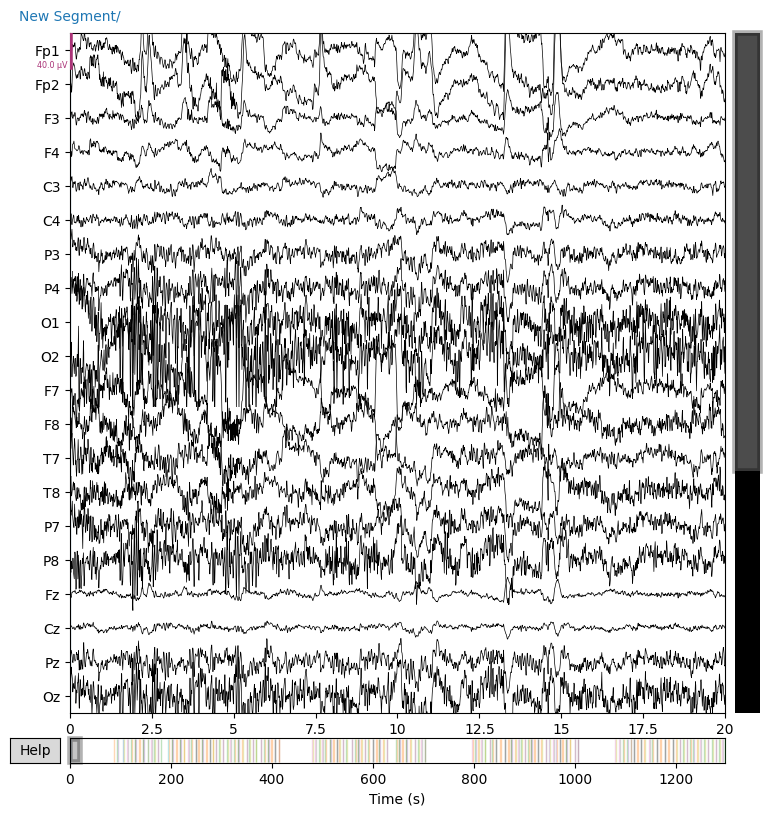

In [14]:
notch_freq = 50.0 # Hz

filtered_50hz = raw.copy().notch_filter(freqs=notch_freq )
filtered_raw = filtered_50hz.copy().filter(l_freq=0.3, h_freq=30, method='iir', iir_params={'order': 2, 'ftype': 'butter'})
fig = filtered_raw.plot(duration = 20)

### Remove eyeblinks and eyemovements using ICA

The MNE-library offers functions that can be used for independent component analysis. We will use two different approaches here. The first approach is to look at the obtained ICA components, and to manually select which components we want to remove. In the second approach, we will make use of the function 'ica.find_bads_eog'. Use [this](https://mne.tools/stable/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html#tut-artifact-ica) tutorial as guidance for both approaches.

Tip: make a copy of your filtered data to continue working, with the .copy() function. This will allow you to go back to the data before the ICA-component removal without having to rerun the entire notebook.

#### Approach 1: Manually select the ICA components to remove

**Question 5:** Perform the independent component analysis and plot both the time-series of the components and the topographies. Based on these images, remove the ICA components containing eyeblinks and eyemovements.

In [15]:
ica = ICA(n_components=31, random_state=97, max_iter=800)
ica.fit(filtered_raw)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 20.8s.


<ICA | raw data decomposition, method: fastica (fit in 63 iterations on 649000 samples), 31 ICA components (31 PCA components available), channel types: eeg, no sources marked for exclusion>

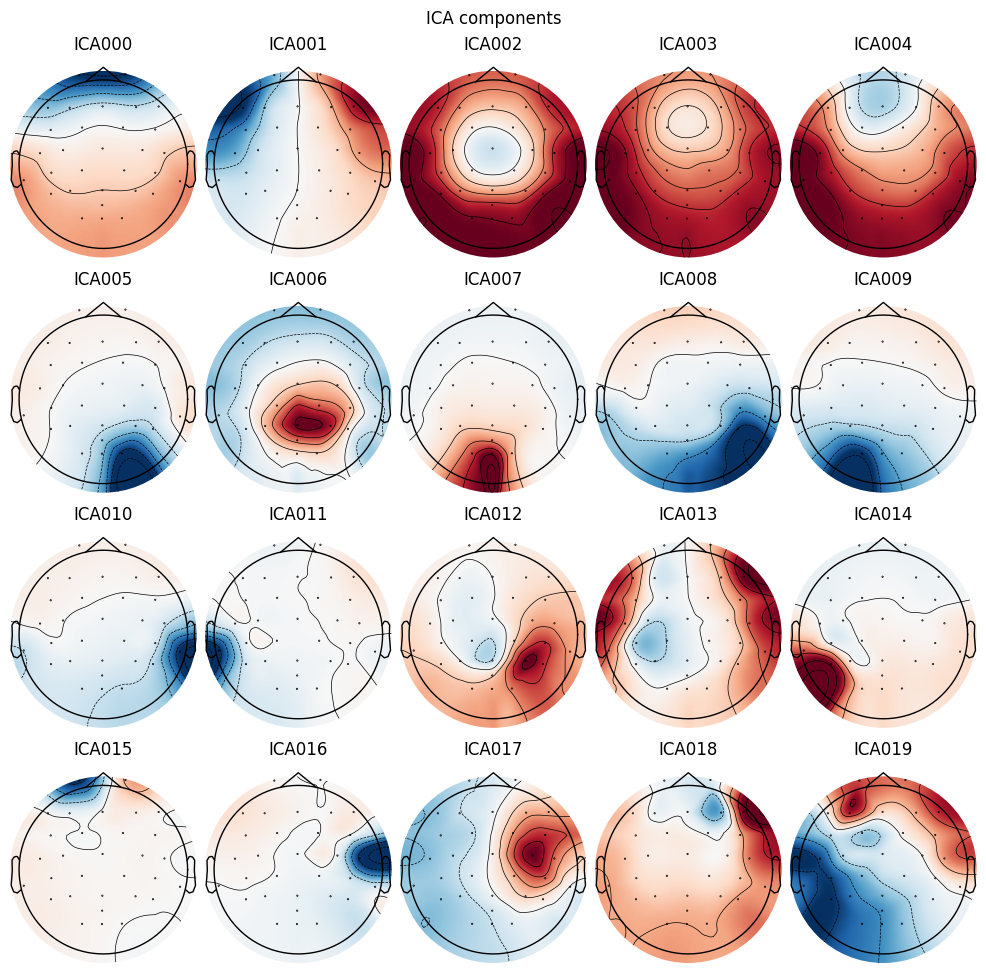

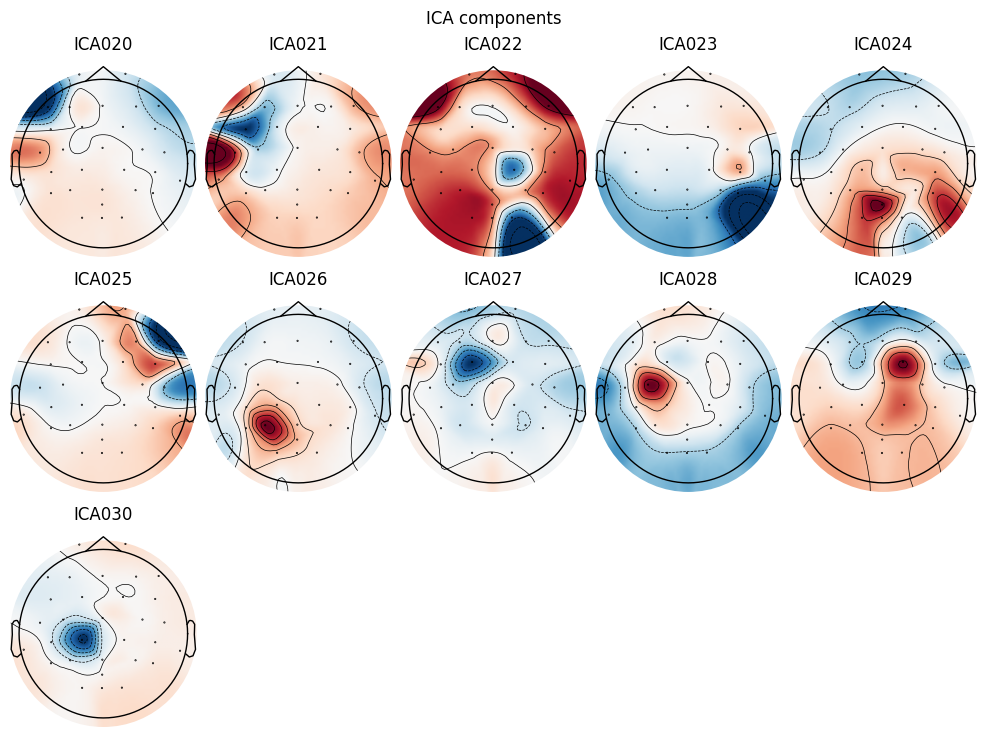

Creating RawArray with float64 data, n_channels=31, n_times=649000
    Range : 0 ... 648999 =      0.000 ...  1297.998 secs
Ready.


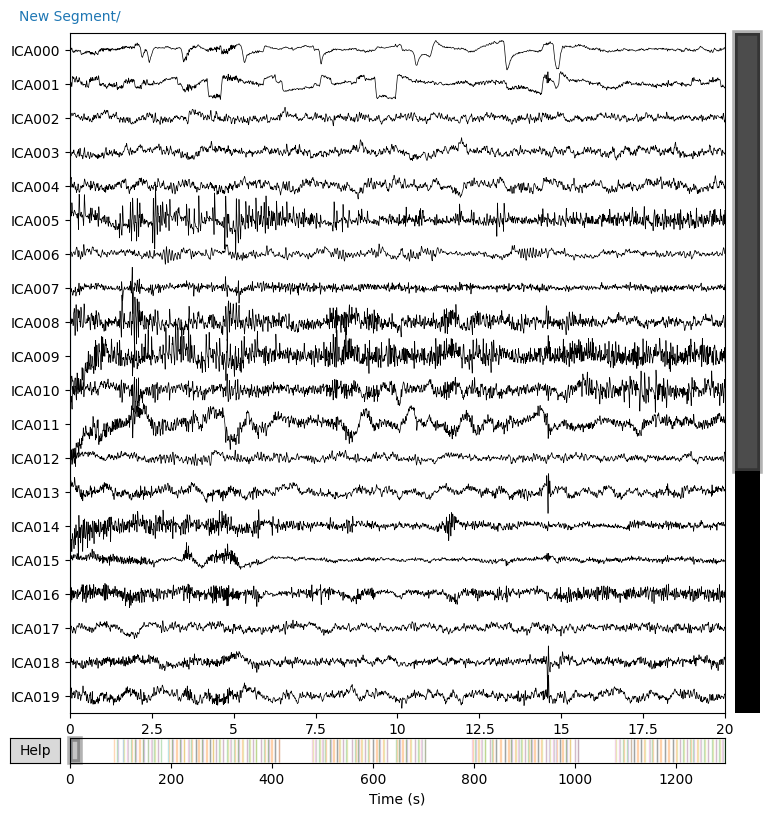

In [16]:
fig = ica.plot_components()
fig = ica.plot_sources(filtered_raw)

**artifact removal**  
use both info from topomap and time series;  
In topo map, ICA001 shows symmerical on left and right, clear line inbetween, heavy weight in frontal, indicating the eyeball movement(left right, on time series it's block waves)  
In time series, ica000 show clear eye blinking pattern (N)

In [17]:
#remove components with eye blink and eye movement
ica.exclude = [0,1]
reconstructed_raw = filtered_raw.copy()
ica.apply(reconstructed_raw)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components


<RawBrainVision | ExpWV_D1M02.eeg, 31 x 649000 (1298.0 s), ~153.5 MiB, data loaded>

#### Approach 2: Use the ica.find_bad_eog function

**Question 6:** Find out what exactly this function does. Notice that this function needs an EOG channel, which we did not record. How can you still use this function?

Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



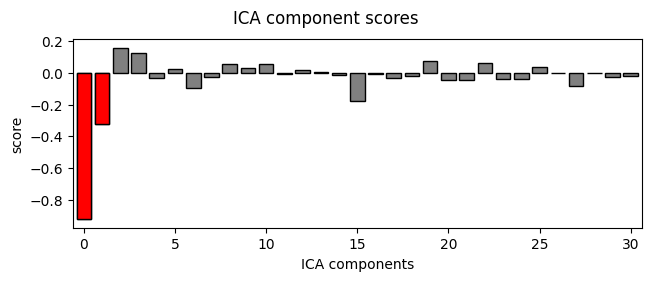

In [18]:
ica.exclude = []
eog_indice, eog_scores = ica.find_bads_eog(filtered_raw, ch_name='Fp1')
ica.exclude = eog_indice

fig = ica.plot_scores(eog_scores)

**Answer 6:**

 **ica.find_bads_eog function:** As it's name suggests, this function helps detecting EOG components based on correlation (Pearson correlation) with an EOG channel.

 It first makes the recorded signals into independent components and then finds the correlation value for each component and an EOG channel making use also of a thresholding component based on adaptative z-scoring for an easier filtering out of undesired channels.


#### Question 7:

Which approach works best and why?

Plot the data again and check if eye artefacts are indeed removed

**Answer 7:**
ica.find_bads_eeg works better, especially when there's EOG recorded or when there's lot's of data. Manually choosing a component based on ICA is too much manual labor, which is not efficient for analysis of a big dataset.


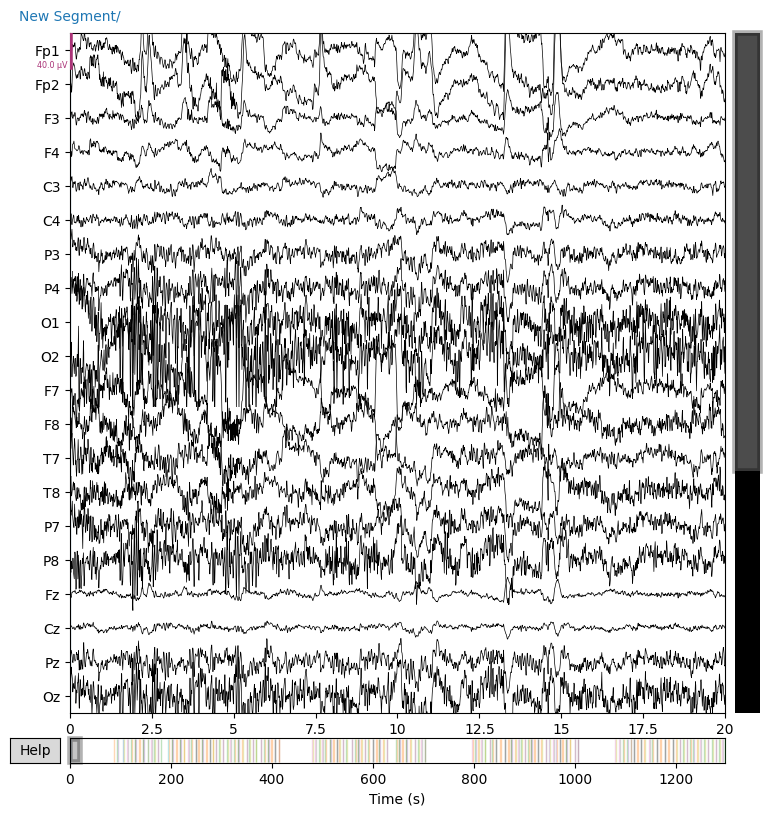

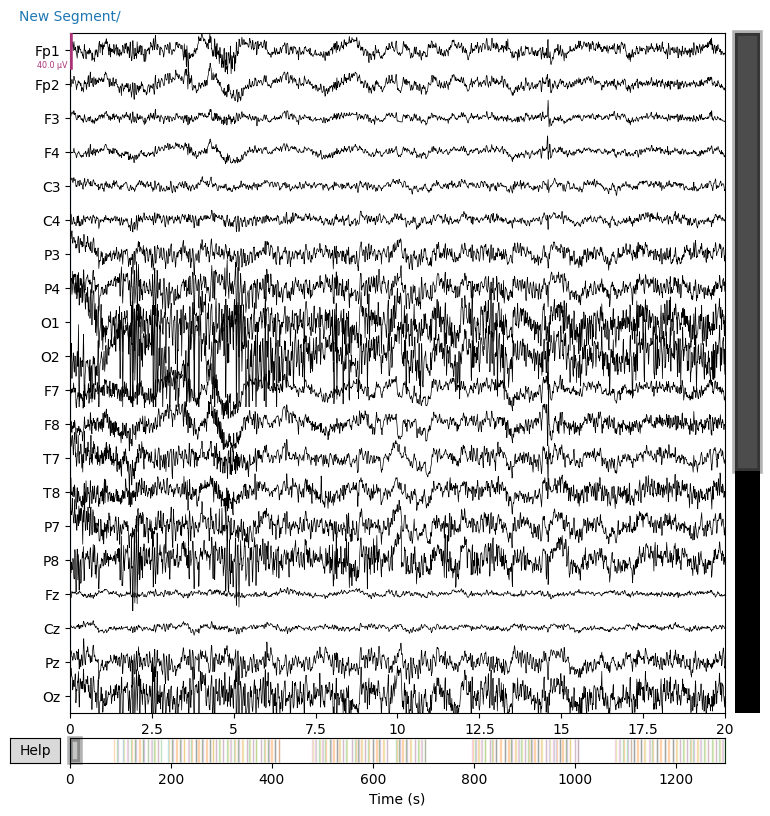

In [19]:
filtered_raw.plot(duration = 20)
fig = reconstructed_raw.plot(duration = 20)

### Rereference the data to the average mastoids (channels TP9 and TP10)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


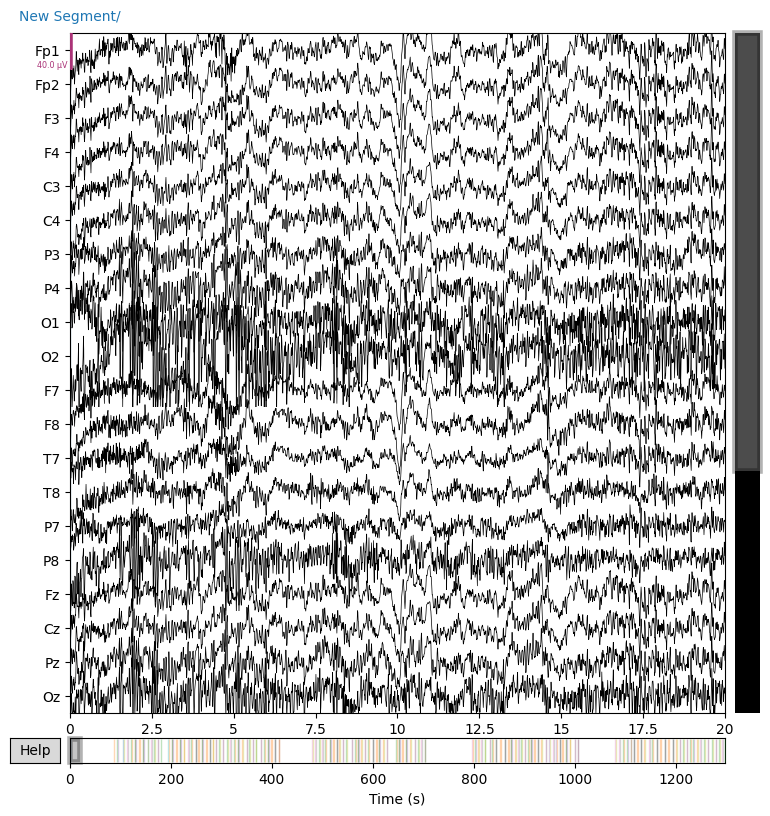

In [20]:
mastoid_channels = ['TP9', 'TP10']
reconstructed_raw.set_eeg_reference(ref_channels=mastoid_channels)
fig = reconstructed_raw.plot(duration = 20)

### Segment the data into epochs, and remove epochs containing artefacts

#### Extract events from the data and plot

When reading the raw data from the BrainVision files, MNE has added the information about the markers as annotations to the raw data. The function 'mne.events_from_annotations' can be used to create an array of events in MNE that is needed to split the data into epochs.

**Question 8:**

* What is the information given in each column of the resulting events-array?
* How many events do you have of each type? Does this correspond to what was said in the introduction?
* Look at the errors that were made. What does this tell you about the rehearsal block and the breaks that are included?

In [21]:
events_data, event_id_data = mne.events_from_annotations(reconstructed_raw,event_id='auto')
print(events_data.shape)

event,counts = np.unique(events_data[:,2], return_counts=True)
id_to_name = {v: str(k) for k, v in event_id_data.items()}

event_counts = [
    {"Event Name": id_to_name.get(int(id), "Unknown"), "Event ID": int(id), "Count": int(count)}
    for id, count in zip(event, counts)
]

print(event_counts)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S 90']
(301, 3)
[{'Event Name': 'Stimulus/S 11', 'Event ID': 11, 'Count': 33}, {'Event Name': 'Stimulus/S 12', 'Event ID': 12, 'Count': 33}, {'Event Name': 'Stimulus/S 14', 'Event ID': 14, 'Count': 33}, {'Event Name': 'Stimulus/S 15', 'Event ID': 15, 'Count': 29}, {'Event Name': 'Stimulus/S 16', 'Event ID': 16, 'Count': 33}, {'Event Name': 'Stimulus/S 18', 'Event ID': 18, 'Count': 33}, {'Event Name': 'Stimulus/S 22', 'Event ID': 22, 'Count': 33}, {'Event Name': 'Stimulus/S 60', 'Event ID': 60, 'Count': 1}, {'Event Name': 'Stimulus/S 70', 'Event ID': 70, 'Count': 3}, {'Event Name': 'Stimulus/S 72', 'Event ID': 72, 'Count': 30}, {'Event Name': 'Stimulus/S 74', 'Event ID': 74, 'Count': 30}, {'Event Name': 'Stimulus

**Answer 8 :**
1. return events (ndarray of(n_events,3)) and event_id(dict).
Events have 3 columns,   
the first one contains the event onset with first sample included, the last column is the event code.   
The second column can contain the signal value of the immediately preceding sample (refelecting the fact that event array sometimes originate from analog coltage channels). In our case it's ignorable since it's all zero.
2. There are 301 events in total.

| Event Name              | Event ID | Count | Theory Count |
|-------------------------|----------|-------|--------------|
| Start sentence (Correct) | 11       | 33    | 30           |
| Adjective (Correct)      | 12       | 33    | 30           |
| Noun (Correct)           | 14       | 33    | 30           |
| Adverb (Correct)         | 15       | 29    | 30           |
| Correct button press     | 72       | 30    | 30           |
| Incorrect button press   | 70       | 3     | 0            |
| Start sentence (Incorrect)| 22      | 33    | 30           |
| Adverb (Incorrect)       | 16       | 33    | 30           |
| Noun (Incorrect)         | 18       | 33    | 30           |
| Correct button press   | 74       | 30    | 30           |
| Incorrect button press  | 76       | 3     | 0            |
| Start of experiment      | 60       | 1     | 1            |
| Start of break           | 80       | 3     | 3            |
| End of break             | 90       | 3     | 3            |
| New Segment              | 99999    | 1     | 1            |


The data doesn't match with the introduction.  

3. We notice there's 3 more correct sentence and 3 more incorrect sentence (the stimuli for the adjective&noun changed accordingly).  
There's 3 break sessions as mentioned in the introduction.

#### Remove the events from the rehearsal block

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\3847135497.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events=events_data, event_id=event_id_data, sfreq=reconstructed_raw.info["sfreq"])


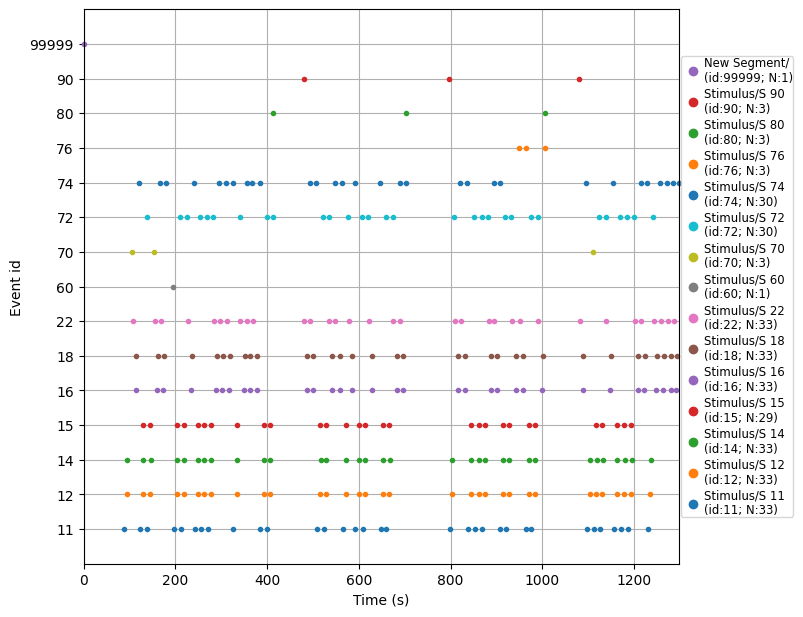

In [22]:
fig = mne.viz.plot_events(events=events_data, event_id=event_id_data, sfreq=reconstructed_raw.info["sfreq"])

In [23]:
s60_event = events_data[events_data[:, 2] == 60]

filtered_events = events_data[(events_data[:, 0] >= s60_event[0, 0]) | (events_data[:, 2] == 99999)]

print(filtered_events.shape)

(275, 3)


#### (Extra: remove all events to which an incorrect response was given)

In [24]:
#only the 'incorrect response'
Incorrect_id = [70,76]
filtered_events_new =filtered_events[~np.isin(filtered_events[:,2],Incorrect_id)]
print(filtered_events_new.shape)


event_id_new = event_id_data.copy()
event_id_new.pop('Stimulus/S 70', None)
event_id_new.pop('Stimulus/S 76', None)

(271, 3)


76

<ipython-input-19-0766d96800fa>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events=filtered_events_new, event_id=event_id_new, sfreq=reconstructed_raw.info["sfreq"])


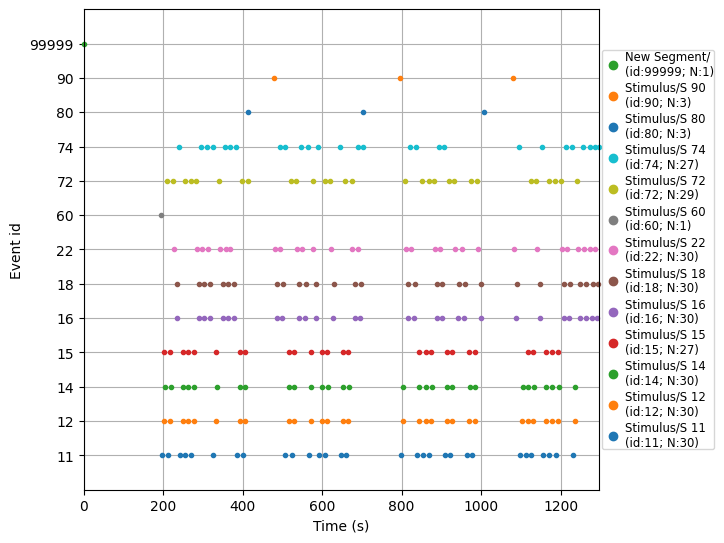

In [ ]:
fig = mne.viz.plot_events(events=filtered_events_new, event_id=event_id_new, sfreq=reconstructed_raw.info["sfreq"])

#### Create epochs from the data

We will split the data into epochs based on the events. Use for both conditions the second word, i.e. the adjective in the correct condition and the adverb in the incorrect condition. Create epochs going from 300 ms before the event to 1500 ms after the event. Use [this](https://mne.tools/stable/auto_tutorials/intro/plot_10_overview.html#detecting-experimental-events) tutorial to help you. Take into account:
* Use the pre-event time as a baseline
* Epochs with artefacts need to be removed
    * Maximal peak-to-peak: 200 µV
    * Minimal activity needed to not be considered a flat signal: 1 µV
    * Minimal allowed amplitude: -100 µV
    * Maximal allowed amplitude: 100 µV
    
Note: not necessarily all artefact removal methods exist in MNE. How can you then still remove the artefacts? (Hint: use the functions epochs.drop() and epochs.get_data)

**Question 9:** How many epochs are retained after artefact removal?

Play around with the parameters that were given for the artefact removal.

In [25]:
reject_criteria = dict(eeg=200e-6)   # reject works with max peak-to-peak amplitude for EEG channels

event_dict = {
    'correct': 12,
    'incorrect': 16, }

epochs = mne.Epochs(
    reconstructed_raw,
    filtered_events_new,
    event_id=event_dict,
    tmin=-0.3,
    tmax=1.5,
    reject=reject_criteria,
    preload=True,
)

Not setting metadata
60 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 901 original time points ...
0 bad epochs dropped


In [26]:
epochs_data = epochs.get_data()

artifact_epochs = []

for i, epoch in enumerate(epochs_data):

    has_flat_signal = (np.ptp(epoch, axis=1) < 1e-6).any()
    has_low_amplitude = (epoch.min(axis=1) < -100e-6).any()
    has_high_amplitude = (epoch.max(axis=1) > 100e-6).any()

    if has_flat_signal or has_low_amplitude or has_high_amplitude:
        artifact_epochs.append(i)

epochs.drop(artifact_epochs)

Dropped 0 epochs: 


<Epochs | 60 events (all good), -0.3 – 1.5 s (baseline -0.3 – 0 s), ~12.8 MiB, data loaded,
 'correct': 30
 'incorrect': 30>

**Answer 9 :**
For the first subject, there's 60 epochs left after the artefact removal.

### Plot the evoked potential

**Question 10:** Calculate the evoked potentials and plot the evoked potentials for both conditions on 1 figure. To keep the figure clear, use only the Pz channel. Also create a plot of the difference wave between both conditions.

In [27]:
evoked_correct = epochs['correct'].average()
evoked_incorrect = epochs['incorrect'].average()

channel = 'Pz'
evoked_correct_pz = evoked_correct.copy().pick([channel])
evoked_incorrect_pz = evoked_incorrect.copy().pick([channel])

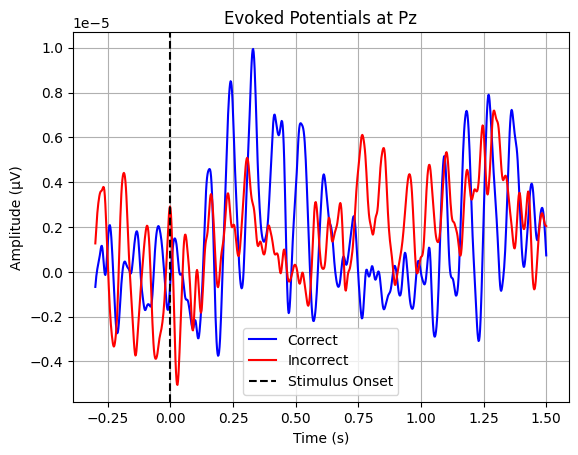

In [28]:
plt.plot(evoked_correct.times, evoked_correct_pz.data.T, label='Correct', color='blue')
plt.plot(evoked_incorrect.times, evoked_incorrect_pz.data.T, label='Incorrect', color='red')

plt.title(f'Evoked Potentials at {channel}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(0, color='black', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)

plt.show()

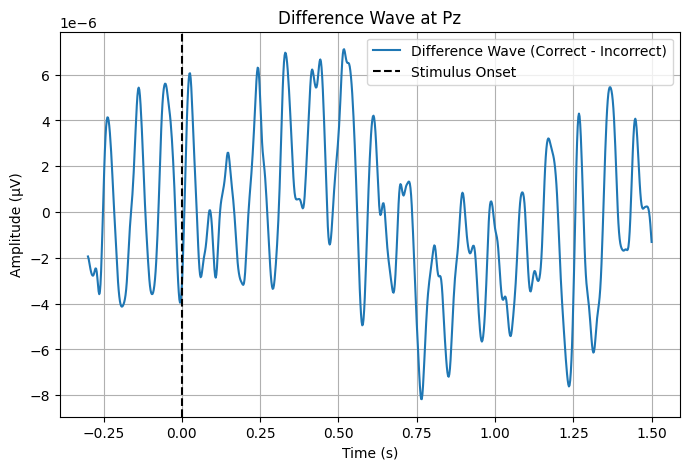

In [29]:
difference_wave = evoked_correct_pz.copy()
difference_wave.data = evoked_correct_pz.data - evoked_incorrect_pz.data

plt.figure(figsize=(8, 5))
plt.plot(evoked_correct.times, difference_wave.data.T, label='Difference Wave (Correct - Incorrect)')

plt.title(f'Difference Wave at {channel}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(0, color='black', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)

plt.show()

## Step 3: Preprocess all data and create the grand-average evoked potential

**Question 10:** Create a function that combines all preprocessing steps. Use this function to preprocess the data of each subject, and average the obtained evoked potentials to obtain the grand-average. Plot the grand average of both conditions for channel 'Pz' in one figure.

For the removal of the eye-artefacts, use the second (automatic) approach to save time.

**Question 11:** Finally, plot topographies for both conditions at different time-points in the epoch. What do you notice?

In [30]:
def pipeline(file):

    raw = mne.io.read_raw_brainvision(file, preload=True)
    raw.set_montage('standard_1020')
    filtered_50hz = raw.copy().notch_filter(freqs=50.0 )
    filtered_raw = filtered_50hz.copy().filter(l_freq=0.3, h_freq=30, method='iir', iir_params={'order': 2, 'ftype': 'butter'})

    ica = ICA(n_components=31, random_state=97, max_iter=800)
    ica.fit(filtered_raw)
    ica.exclude = []
    eog_indice, eog_scores = ica.find_bads_eog(filtered_raw, ch_name='Fp1')
    ica.exclude = eog_indice
    reconstructed_raw = filtered_raw.copy()
    ica.apply(reconstructed_raw)

    mastoid_channels = ['TP9', 'TP10']
    reconstructed_raw.set_eeg_reference(ref_channels=mastoid_channels)

    events_data, event_id_data = mne.events_from_annotations(reconstructed_raw,event_id='auto')
    s60_event = events_data[events_data[:, 2] == 60]
    filtered_events = events_data[(events_data[:, 0] >= s60_event[0, 0]) | (events_data[:, 2] == 99999)]
    Incorrect_id = [70,76]
    filtered_events_new =filtered_events[~np.isin(filtered_events[:,2],Incorrect_id)]
    event_id_new = event_id_data.copy()
    event_id_new.pop('Stimulus/S 70', None)
    event_id_new.pop('Stimulus/S 76', None)

    reject_criteria = dict(eeg=200e-6)
    event_dict = {'correct': 12,'incorrect': 16, }
    epochs = mne.Epochs(
        reconstructed_raw,
        filtered_events_new,
        event_id=event_dict,
        tmin=-0.3,
        tmax=1.5,
        reject=reject_criteria,
        preload=True,
    )

    epochs_data = epochs.get_data()
    artifact_epochs = [i for i, epoch in enumerate(epochs_data) if
                       (np.ptp(epoch, axis=1) < 1e-6).any() or
                       (epoch.min(axis=1) < -100e-6).any() or
                       (epoch.max(axis=1) > 100e-6).any()]
    epochs.drop(artifact_epochs)

    evoked_correct = epochs['correct'].average()
    evoked_incorrect = epochs['incorrect'].average()

    return evoked_correct, evoked_incorrect


In [31]:
evoked_correct_list = []
evoked_incorrect_list = []

for file in files:
    evoked_correct, evoked_incorrect = pipeline(file)
    evoked_correct_list.append(evoked_correct)
    evoked_incorrect_list.append(evoked_incorrect)

grand_average_correct = mne.grand_average(evoked_correct_list)
grand_average_incorrect = mne.grand_average(evoked_incorrect_list)

channel = 'Pz'
grand_correct_pz = grand_average_correct.copy().pick([channel])
grand_incorrect_pz = grand_average_incorrect.copy().pick([channel])


Extracting parameters from Data/Data\ExpWV_D1M02.vhdr...
Setting channel info structure...
Reading 0 ... 648999  =      0.000 ...  1297.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 20.4s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.6s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 match

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 901 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Extracting parameters from Data/Data\ExpWV_D1M05.vhdr...
Setting channel info structure...
Reading 0 ... 521989  =      0.000 ...  1043.978 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 20.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 15.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 16.3s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 17.1s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 11.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not sett

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 18.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not sett

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.5s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matc

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 16.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 17.3s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 10.4s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 15.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 17.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 17.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 10.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 901 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Extracting parameters from Data/Data\ExpWV_D3M03.vhdr...
Setting channel info structure...
Reading 0 ... 526119  =      0.000 ...  1052.238 secs...
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.6s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not sett

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 9.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.3s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 22.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 10.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S 

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 22.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 18.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 15.1s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 match

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 11.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 901 original time points ...
0 bad epochs dropped
Dropped 1 epoch: 12
Extracting parameters from Data/Data\ExpWV_D4M05.vhdr...
Setting channel info structure...
Reading 0 ... 537429  =      0.000 ...  1074.858 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 20.5s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not sett

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.0s.
Using EOG channel: Fp1


C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:9: RuntimeWarning: Using n_components=31 (resulting in n_components_=31) may lead to an unstable mixing matrix estimation because the ratio between the largest (31) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 27
  ica.fit(filtered_raw)


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 15.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.6s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 17.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.7s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s



Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 9.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not sett

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 9.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 16.6s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.1s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 25.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not set

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.6s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting 

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 12.3s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 16.4s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 15.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimul

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.5s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s



FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting metadata
60 matching events found
Setting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.2s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 80', 'Stimulus/S 90']
Not setting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 14.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 11.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 13.8s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 16.6s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 9.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimulu

C:\Users\cesar_5w126xu\AppData\Local\Temp\ipykernel_31100\720652955.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 0.3 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.30, 30.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components
Fitting ICA took 11.0s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 18', 'Stimulus/S 22', 'Stimulus/S 60', 'Stimulus/S 70', 'Stimulus/S 72', 'Stimulus/S 74', 'Stimulus/S 76', 'Stimul

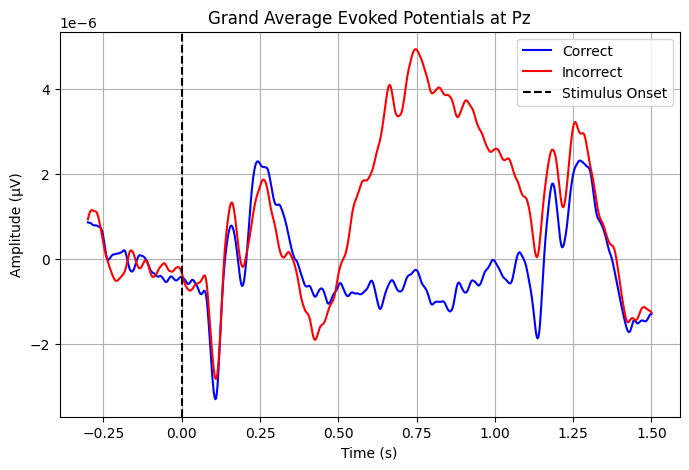

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(grand_correct_pz.times, grand_correct_pz.data.T, label='Correct', color='blue')
plt.plot(grand_incorrect_pz.times, grand_incorrect_pz.data.T, label='Incorrect', color='red')
plt.axvline(0, color='black', linestyle='--', label='Stimulus Onset')
plt.title(f'Grand Average Evoked Potentials at {channel}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.show()

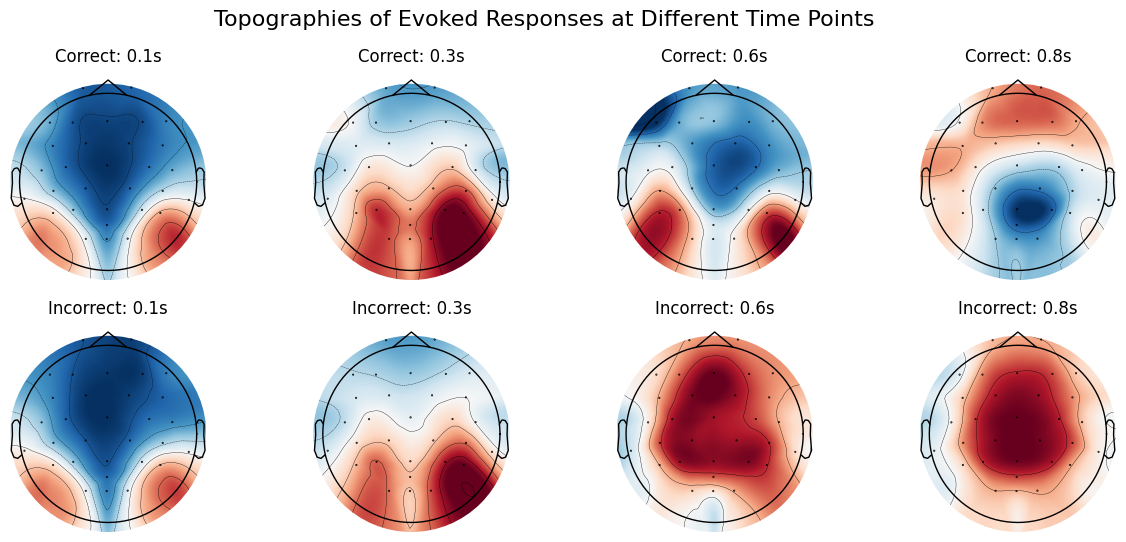

In [33]:
time_points = [0.1,0.3,0.6,0.8]

fig, axes = plt.subplots(2, len(time_points), figsize=(15, 6))

# Loop through time points and plot topographies
for i, t in enumerate(time_points):
    grand_average_correct.plot_topomap(times=t, axes=axes[0, i],colorbar=False, show=False)
    axes[0, i].set_title(f'Correct: {t:.1f}s')

    grand_average_incorrect.plot_topomap(times=t, axes=axes[1, i],colorbar =False, show=False)
    axes[1, i].set_title(f'Incorrect: {t:.1f}s')

# Add overall figure title
fig.suptitle("Topographies of Evoked Responses at Different Time Points", fontsize=16)
plt.show()

**Answer 10 & 11:**
We choose time points at 0.1, 0.3, 0.6 and 0.8s, all we assume there's event-related activities.  
(As we learned in class,) 0.1s after sentence started is typically the ERP of visual response, and P300 is where we find post-response evaluation, and P600 reflects the language understanding and processing, with a larger response when syntactic violations in sentence compared to grammatically correct sentence. We notice from the grand average evoked potentials that in this study, P600 shows in the range of (0.6,1)s, with it's peak around 0.75s.  
We can tell from the topographies, that in correct sentence and incorrect sentence they have similar topographies at time 0.1s and 0.3s, matches our expectation that the subject is paying attention and have reaction to the visual changes (words on screen).  And the difference at 0.6s and 0.8s is obvient, show the different response for the syntactic violations.